🔍 Archivos encontrados: 1


📂 Cargando CSV: 100%|██████████| 1/1 [00:00<00:00, 30.34it/s]

📊 Dataset combinado: (1989, 7)
After SMOTE: (2510, 100, 6), pos count: 1255


Epoch 1/60 | Train Loss: 0.712240 | Val Recall@0.5: 0.5000
Epoch 2/60 | Train Loss: 0.219047 | Val Recall@0.5: 0.3125
Epoch 3/60 | Train Loss: 0.067408 | Val Recall@0.5: 0.1875
Epoch 4/60 | Train Loss: 0.036510 | Val Recall@0.5: 0.1250
Epoch 5/60 | Train Loss: 0.027690 | Val Recall@0.5: 0.1562
Epoch 6/60 | Train Loss: 0.024401 | Val Recall@0.5: 0.1250
Epoch 7/60 | Train Loss: 0.005935 | Val Recall@0.5: 0.1250
Epoch 8/60 | Train Loss: 0.005174 | Val Recall@0.5: 0.1250
Epoch 9/60 | Train Loss: 0.006394 | Val Recall@0.5: 0.1250
Epoch 10/60 | Train Loss: 0.003846 | Val Recall@0.5: 0.1250
Epoch 11/60 | Train Loss: 0.003284 | Val Recall@0.5: 0.1250
🛑 Early stopping activado
🔎 Mejor threshold balanceado: 0.2815
✅ Evaluación en test con threshold optimizado

=== Classification Report ===
              precision    recall  f1-score   support

    No Caida     0.0000    0.0000    0.0000     284.0
       Caida     0.0000    0.0000    0.0000       0.0

    accuracy                         0.0000  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

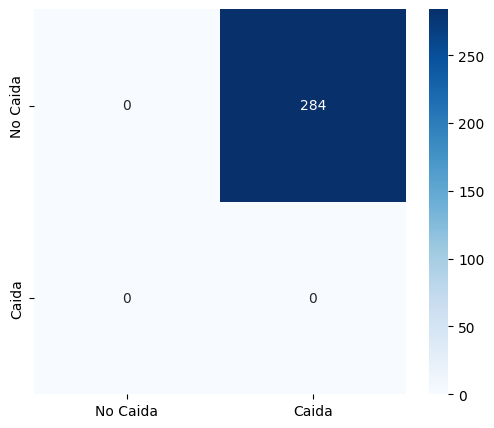

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Evaluación en test con threshold=0.5 (referencia)

=== Classification Report ===
              precision    recall  f1-score   support

    No Caida     1.0000    0.8873    0.9403       284
       Caida     0.0000    0.0000    0.0000         0

    accuracy                         0.8873       284
   macro avg     0.5000    0.4437    0.4701       284
weighted avg     1.0000    0.8873    0.9403       284

Confusion matrix:
 [[252  32]
 [  0   0]]


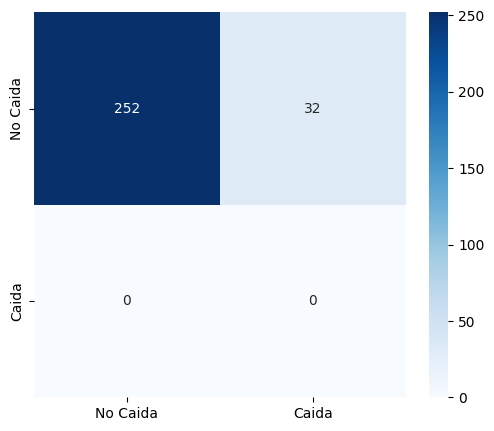

In [ ]:
# ========================================
# PIPELINE FINAL DE DETECCIÓN DE CAÍDAS
# ========================================

!pip install imbalanced-learn --quiet
!pip install tqdm --quiet
!pip install seaborn --quiet

import os, glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# ========================
# CONFIGURACIÓN
# ========================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 60
SEQ_LEN = 100
LR = 1e-3
torch.manual_seed(42)
np.random.seed(42)

# ========================
# CARGA Y PROCESAMIENTO DE CSVs
# ========================
def load_data_from_folder(folder_path, seq_len=100):
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    print(f"🔍 Archivos encontrados: {len(all_files)}")
    dfs = []
    for f in tqdm(all_files, desc="📂 Cargando CSV"):
        df = pd.read_csv(f)
        df = df.drop(columns=[c for c in ["ID","TIMESTAMP"] if c in df.columns], errors="ignore")
        if "TOGGLE_VAR" in df.columns:
            df = df.rename(columns={"TOGGLE_VAR":"label"})
        for col in df.columns:
            if df[col].dtype=="object":
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(",","", regex=False), errors="coerce")
        dfs.append(df)

    data = pd.concat(dfs, ignore_index=True).dropna().reset_index(drop=True)
    print(f"📊 Dataset combinado: {data.shape}")

    X = data.drop(columns=["label"]).values.astype(np.float32)
    y = data["label"].values.astype(np.int64)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    sequences, labels = [], []
    for i in range(len(X) - seq_len):
        sequences.append(X[i:i+seq_len])
        labels.append(y[i+seq_len])
    X_seq, y_seq = np.array(sequences), np.array(labels)

    n = len(X_seq)
    train_end = int(0.7 * n)
    valid_end = int(0.85 * n)

    return (X_seq[:train_end], y_seq[:train_end]), (X_seq[train_end:valid_end], y_seq[train_end:valid_end]), (X_seq[valid_end:], y_seq[valid_end:])

# ========================
# MODELO CNN + LSTM
# ========================
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, cnn_channels=32, lstm_hidden=128, lstm_layers=1, dropout=0.5):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, cnn_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(cnn_channels, lstm_hidden, lstm_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(lstm_hidden*2, 64)
        self.fc2 = nn.Linear(64, 1)
    def forward(self, x):
        x = x.transpose(1,2)
        x = self.relu(self.conv1(x))
        x = x.transpose(1,2)
        out,_ = self.lstm(x)
        out = out[:,-1,:]
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        return self.fc2(out).squeeze(-1)

# ========================
# EARLY STOPPING POR RECALL
# ========================
class EarlyStopRecall:
    def __init__(self, patience=10, save_path="best_model.pth"):
        self.patience = patience
        self.save_path = save_path
        self.best_recall = -1.0
        self.counter = 0
    def step(self, recall, model):
        if recall > self.best_recall + 1e-8:
            self.best_recall = recall
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
        else:
            self.counter += 1
        return self.counter >= self.patience

# ========================
# TRAINING
# ========================
def train(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=60, earlystop=None):
    for epoch in range(epochs):
        model.train()
        total_loss=0
        for X, y in train_loader:
            X, y = X.to(DEVICE), y.to(DEVICE).float()
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        y_true, y_logits = [], []
        val_loss=0
        with torch.no_grad():
            for X, y in valid_loader:
                X, y = X.to(DEVICE), y.to(DEVICE).float()
                logits = model(X)
                loss = criterion(logits, y)
                val_loss += loss.item()
                y_true.extend(y.cpu().numpy())
                y_logits.extend(torch.sigmoid(logits).cpu().numpy())
        y_true = np.array(y_true)
        y_logits = np.array(y_logits)
        val_pred = (y_logits>=0.5).astype(int)
        val_recall = np.sum((y_true==1)&(val_pred==1))/max(np.sum(y_true==1),1)
        scheduler.step(val_loss/len(valid_loader))
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss/len(train_loader):.6f} | Val Recall@0.5: {val_recall:.4f}")
        if earlystop is not None and earlystop.step(val_recall, model):
            print("🛑 Early stopping activado")
            break
    if earlystop is not None and os.path.exists(earlystop.save_path):
        model.load_state_dict(torch.load(earlystop.save_path, map_location=DEVICE))
    return model

# ========================
# THRESHOLD OPTIMIZADO BALANCEADO
# ========================
def optimize_threshold_balanced(y_true, y_probs, alpha=0.7):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    scores = recall * alpha + precision * (1-alpha)
    best_idx = np.argmax(scores)
    best_thr = thresholds[best_idx] if best_idx<len(thresholds) else 0.5
    return best_thr

# ========================
# EVALUACIÓN
# ========================
def evaluate(model, loader, threshold=0.5):
    model.eval()
    y_true, y_logits = [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(DEVICE)
            logits = model(X)
            y_logits.extend(torch.sigmoid(logits).cpu().numpy())
            y_true.extend(y.numpy())
    y_true = np.array(y_true)
    y_logits = np.array(y_logits)
    y_pred = (y_logits>=threshold).astype(int)
    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, digits=4, target_names=["No Caida","Caida"]))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Caida","Caida"], yticklabels=["No Caida","Caida"])
    plt.show()
    return y_true, y_logits, y_pred

# ========================
# MAIN PIPELINE
# ========================
if __name__=="__main__":
    # 1) cargar datos
    (X_train, y_train), (X_valid, y_valid), (X_test, y_test) = load_data_from_folder("/content/content", seq_len=SEQ_LEN)

    # 2) SMOTE
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train_flat, y_train)
    X_res = X_res.reshape(-1, SEQ_LEN, X_train.shape[2])
    print(f"After SMOTE: {X_res.shape}, pos count: {np.sum(y_res==1)}")

    # 3) datasets y loaders
    train_ds = TensorDataset(torch.from_numpy(X_res).float(), torch.from_numpy(y_res).long())
    valid_ds = TensorDataset(torch.from_numpy(X_valid).float(), torch.from_numpy(y_valid).long())
    test_ds  = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # 4) Modelo
    model = CNNLSTM(input_dim=X_train.shape[2]).to(DEVICE)
    pos_weight = torch.tensor([2.0], dtype=torch.float32).to(DEVICE)  # ajustado para no saturar Caida
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)
    earlystop = EarlyStopRecall(patience=10)

    # 5) Entrenamiento
    model = train(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=EPOCHS, earlystop=earlystop)

    # 6) Threshold optimizado balanceado
    y_val_logits = []
    with torch.no_grad():
        for X, y in valid_loader:
            X = X.to(DEVICE)
            logits = model(X)
            y_val_logits.extend(torch.sigmoid(logits).cpu().numpy())
    y_val_logits = np.array(y_val_logits)
    best_thr = optimize_threshold_balanced(y_valid, y_val_logits, alpha=0.7)
    print(f"🔎 Mejor threshold balanceado: {best_thr:.4f}")

    # 7) Evaluación final
    print("✅ Evaluación en test con threshold optimizado")
    evaluate(model, test_loader, threshold=best_thr)

    print("✅ Evaluación en test con threshold=0.5 (referencia)")
    evaluate(model, test_loader, threshold=0.5)

🔍 Archivos encontrados: 1


📂 Cargando CSV: 100%|██████████| 1/1 [00:00<00:00, 89.75it/s]

📊 Dataset combinado: (1989, 7)
After SMOTE: (1252, 100, 6), pos count: 626
Calculated positive weight: 0.50


Epoch 1/100 | Train Loss: 0.502589 | Val Recall@0.5: 0.3824
Epoch 2/100 | Train Loss: 0.367214 | Val Recall@0.5: 0.5882
Epoch 3/100 | Train Loss: 0.190769 | Val Recall@0.5: 0.6176
Epoch 4/100 | Train Loss: 0.127792 | Val Recall@0.5: 0.7941
Epoch 5/100 | Train Loss: 0.090000 | Val Recall@0.5: 0.7647
Epoch 6/100 | Train Loss: 0.077918 | Val Recall@0.5: 0.7941
Epoch 7/100 | Train Loss: 0.070268 | Val Recall@0.5: 0.9412
Epoch 8/100 | Train Loss: 0.113104 | Val Recall@0.5: 0.7941
Epoch 9/100 | Train Loss: 0.054209 | Val Recall@0.5: 0.7059
Epoch 10/100 | Train Loss: 0.069775 | Val Recall@0.5: 0.8529
Epoch 11/100 | Train Loss: 0.052473 | Val Recall@0.5: 0.8235
Epoch 12/100 | Train Loss: 0.040580 | Val Recall@0.5: 0.7647
Epoch 13/100 | Train Loss: 0.035336 | Val Recall@0.5: 0.8529
Epoch 14/100 | Train Loss: 0.029727 | Val Recall@0.5: 0.9412
Epoch 15/100 | Train Loss: 0.026129 | Val Recall@0.5: 0.8529
Epoch 16/100 | Train Loss: 0.018837 | Val Recall@0.5: 0.8235
Epoch 17/100 | Train Loss: 0.0310

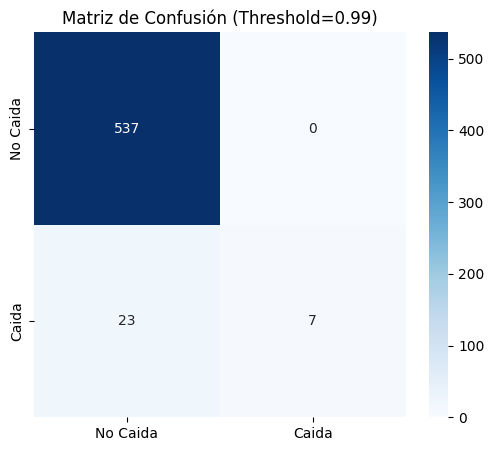


✅ Evaluación en test con threshold=0.5 (referencia)

=== Classification Report ===
              precision    recall  f1-score   support

    No Caida     0.9960    0.9162    0.9544       537
       Caida     0.3836    0.9333    0.5437        30

    accuracy                         0.9171       567
   macro avg     0.6898    0.9248    0.7491       567
weighted avg     0.9635    0.9171    0.9327       567

Confusion matrix:
 [[492  45]
 [  2  28]]


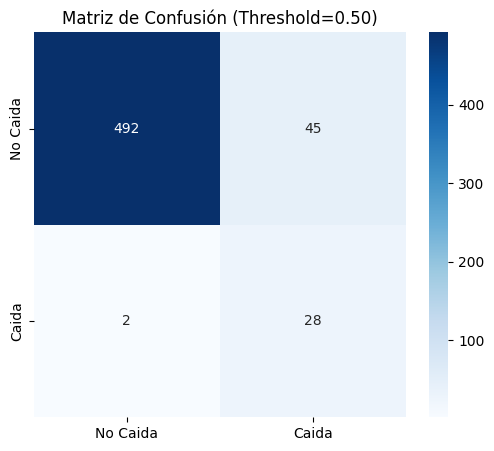

In [ ]:
import os, glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# ========================
# CONFIGURACIÓN
# ========================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS = 100
SEQ_LEN = 100
LR = 1e-4
torch.manual_seed(42)
np.random.seed(42)

# ========================
# CARGA Y PROCESAMIENTO DE CSVs
# ========================
def load_data_from_folder(folder_path, seq_len=100):
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    print(f"🔍 Archivos encontrados: {len(all_files)}")
    if not all_files:
        print("❌ No se encontraron archivos CSV. Asegúrate de que la ruta sea correcta.")
        return None, None, None
    dfs = []
    for f in tqdm(all_files, desc="📂 Cargando CSV"):
        df = pd.read_csv(f)
        df = df.drop(columns=[c for c in ["ID","TIMESTAMP"] if c in df.columns], errors="ignore")
        if "TOGGLE_VAR" in df.columns:
            df = df.rename(columns={"TOGGLE_VAR":"label"})
        for col in df.columns:
            if df[col].dtype=="object":
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(",","", regex=False), errors="coerce")
        dfs.append(df)

    data = pd.concat(dfs, ignore_index=True).dropna().reset_index(drop=True)
    print(f"📊 Dataset combinado: {data.shape}")

    X = data.drop(columns=["label"]).values.astype(np.float32)
    y = data["label"].values.astype(np.int64)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    sequences, labels = [], []
    for i in range(len(X) - seq_len):
        sequences.append(X[i:i+seq_len])
        labels.append(y[i+seq_len])
    X_seq, y_seq = np.array(sequences), np.array(labels)

    # === División de datos estratificada ===
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    for train_index, test_index in sss.split(X_seq, y_seq):
        X_temp, X_test = X_seq[train_index], X_seq[test_index]
        y_temp, y_test = y_seq[train_index], y_seq[test_index]

    sss_valid = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    for train_index, valid_index in sss_valid.split(X_temp, y_temp):
        X_train, X_valid = X_temp[train_index], X_temp[valid_index]
        y_train, y_valid = y_temp[train_index], y_temp[valid_index]

    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

# ========================
# MODELO CNN + LSTM MEJORADO
# ========================
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, cnn_channels=64, lstm_hidden=256, lstm_layers=2, dropout=0.6): # Aumentado el dropout
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, cnn_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(cnn_channels, lstm_hidden, lstm_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(lstm_hidden*2, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.relu(self.conv1(x))
        x = x.transpose(1, 2)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        return self.fc2(out).squeeze(-1)

# ========================
# EARLY STOPPING POR RECALL
# ========================
class EarlyStopRecall:
    def __init__(self, patience=15, save_path="best_model.pth"): # Aumentada la paciencia
        self.patience = patience
        self.save_path = save_path
        self.best_recall = -1.0
        self.counter = 0
    def step(self, recall, model):
        if recall > self.best_recall + 1e-8:
            self.best_recall = recall
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
        else:
            self.counter += 1
        return self.counter >= self.patience

# ========================
# TRAINING
# ========================
def train(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=100, earlystop=None):
    for epoch in range(epochs):
        model.train()
        total_loss=0
        for X, y in train_loader:
            X, y = X.to(DEVICE), y.to(DEVICE).float()
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        y_true, y_logits = [], []
        val_loss=0
        with torch.no_grad():
            for X, y in valid_loader:
                X, y = X.to(DEVICE), y.to(DEVICE).float()
                logits = model(X)
                loss = criterion(logits, y)
                val_loss += loss.item()
                y_true.extend(y.cpu().numpy())
                y_logits.extend(torch.sigmoid(logits).cpu().numpy())

        y_true = np.array(y_true)
        y_logits = np.array(y_logits)

        num_pos_valid = np.sum(y_true == 1)
        if num_pos_valid > 0:
            val_pred = (y_logits >= 0.5).astype(int)
            val_recall = np.sum((y_true == 1) & (val_pred == 1)) / num_pos_valid
        else:
            val_recall = -1.0

        scheduler.step(val_loss/len(valid_loader))
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss/len(train_loader):.6f} | Val Recall@0.5: {val_recall:.4f}")

        if val_recall >= 0 and earlystop is not None and earlystop.step(val_recall, model):
            print("🛑 Early stopping activado")
            break

    if earlystop is not None and os.path.exists(earlystop.save_path):
        model.load_state_dict(torch.load(earlystop.save_path, map_location=DEVICE))
    return model

# ========================
# THRESHOLD OPTIMIZADO BALANCEADO
# ========================
def optimize_threshold_balanced(y_true, y_probs, alpha=0.3): # Reducimos alpha
    if len(np.unique(y_true)) < 2 or np.sum(y_true) == 0:
        return 0.5
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    scores = recall * alpha + precision * (1 - alpha)
    best_idx = np.argmax(scores)
    best_thr = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    return best_thr

# ========================
# EVALUACIÓN
# ========================
def evaluate(model, loader, threshold=0.5):
    model.eval()
    y_true, y_logits = [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(DEVICE)
            logits = model(X)
            y_logits.extend(torch.sigmoid(logits).cpu().numpy())
            y_true.extend(y.numpy())
    y_true = np.array(y_true)
    y_logits = np.array(y_logits)
    y_pred = (y_logits >= threshold).astype(int)

    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, digits=4, target_names=["No Caida","Caida"]))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Caida", "Caida"], yticklabels=["No Caida", "Caida"])
    plt.title(f"Matriz de Confusión (Threshold={threshold:.2f})")
    plt.show()
    return y_true, y_logits, y_pred

# ========================
# MAIN PIPELINE
# ========================
if __name__=="__main__":
    # 1) Cargar datos y dividir estratificadamente
    (X_train, y_train), (X_valid, y_valid), (X_test, y_test) = load_data_from_folder("/content/content", seq_len=SEQ_LEN)

    # 2) SMOTE
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    n_pos_samples = np.sum(y_train == 1)
    smote_k = 5
    if n_pos_samples > 1:
        smote_k = min(5, n_pos_samples - 1)
        sm = SMOTE(k_neighbors=smote_k, random_state=42)
        X_res, y_res = sm.fit_resample(X_train_flat, y_train)
        X_res = X_res.reshape(-1, SEQ_LEN, X_train.shape[2])
    else:
        print("⚠️ No hay suficientes muestras de la clase 'Caída' para aplicar SMOTE. Se usará el conjunto de entrenamiento original.")
        X_res, y_res = X_train, y_train

    print(f"After SMOTE: {X_res.shape}, pos count: {np.sum(y_res==1)}")

    # 3) Datasets y loaders
    train_ds = TensorDataset(torch.from_numpy(X_res).float(), torch.from_numpy(y_res).long())
    valid_ds = TensorDataset(torch.from_numpy(X_valid).float(), torch.from_numpy(y_valid).long())
    test_ds = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # 4) Modelo
    model = CNNLSTM(input_dim=X_train.shape[2]).to(DEVICE)

    # Calcular pos_weight y reducirlo
    num_neg = np.sum(y_res == 0)
    num_pos = np.sum(y_res == 1)
    pos_weight_val = (num_neg / max(num_pos, 1)) * 0.5  # Se reduce a la mitad
    pos_weight = torch.tensor([pos_weight_val], dtype=torch.float32).to(DEVICE)
    print(f"Calculated positive weight: {pos_weight_val:.2f}")

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=5e-5) # Aumentado weight_decay
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8) # Aumentada la paciencia del scheduler
    earlystop = EarlyStopRecall(patience=15)

    # 5) Entrenamiento
    model = train(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=EPOCHS, earlystop=earlystop)

    # 6) Threshold optimizado balanceado
    y_val_logits = []
    with torch.no_grad():
        for X, y in valid_loader:
            X = X.to(DEVICE)
            logits = model(X)
            y_val_logits.extend(torch.sigmoid(logits).cpu().numpy())

    y_val_logits = np.array(y_val_logits)
    best_thr = optimize_threshold_balanced(y_valid, y_val_logits, alpha=0.3) # Reducimos alpha
    print(f"🔎 Mejor threshold balanceado: {best_thr:.4f}")

    # 7) Evaluación final
    print("\n✅ Evaluación en test con threshold optimizado")
    evaluate(model, test_loader, threshold=best_thr)

    print("\n✅ Evaluación en test con threshold=0.5 (referencia)")
    evaluate(model, test_loader, threshold=0.5)

🔍 Archivos encontrados: 1


📂 Cargando CSV: 100%|██████████| 1/1 [00:00<00:00, 106.68it/s]

📊 Dataset combinado: (1989, 7)
After SMOTE: (1252, 100, 6), pos count: 626
Calculated positive weight: 0.25


Epoch 1/100 | Train Loss: 0.412264 | Val Recall@0.5: 0.0000
Epoch 2/100 | Train Loss: 0.306787 | Val Recall@0.5: 0.2353
Epoch 3/100 | Train Loss: 0.188323 | Val Recall@0.5: 0.5000
Epoch 4/100 | Train Loss: 0.119774 | Val Recall@0.5: 0.6471
Epoch 5/100 | Train Loss: 0.082351 | Val Recall@0.5: 0.7059
Epoch 6/100 | Train Loss: 0.071028 | Val Recall@0.5: 0.5882
Epoch 7/100 | Train Loss: 0.070759 | Val Recall@0.5: 0.7647
Epoch 8/100 | Train Loss: 0.049597 | Val Recall@0.5: 0.7647
Epoch 9/100 | Train Loss: 0.044793 | Val Recall@0.5: 0.6765
Epoch 10/100 | Train Loss: 0.053625 | Val Recall@0.5: 0.6471
Epoch 11/100 | Train Loss: 0.041361 | Val Recall@0.5: 0.6471
Epoch 12/100 | Train Loss: 0.039084 | Val Recall@0.5: 0.8529
Epoch 13/100 | Train Loss: 0.027618 | Val Recall@0.5: 0.8529
Epoch 14/100 | Train Loss: 0.028032 | Val Recall@0.5: 0.8529
Epoch 15/100 | Train Loss: 0.030321 | Val Recall@0.5: 0.8529
Epoch 16/100 | Train Loss: 0.028465 | Val Recall@0.5: 0.7941
Epoch 17/100 | Train Loss: 0.0169

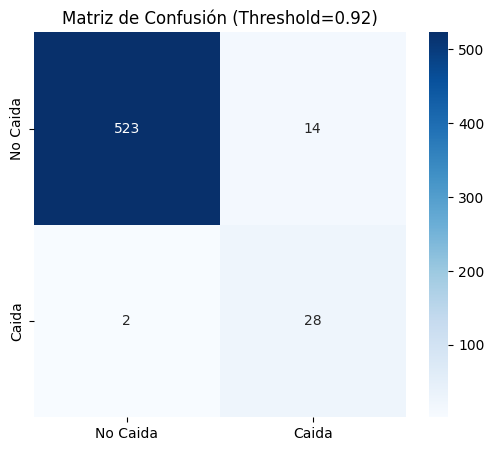


✅ Evaluación en test con threshold=0.5 (referencia)

=== Classification Report ===
              precision    recall  f1-score   support

    No Caida     1.0000    0.9609    0.9801       537
       Caida     0.5882    1.0000    0.7407        30

    accuracy                         0.9630       567
   macro avg     0.7941    0.9804    0.8604       567
weighted avg     0.9782    0.9630    0.9674       567

Confusion matrix:
 [[516  21]
 [  0  30]]


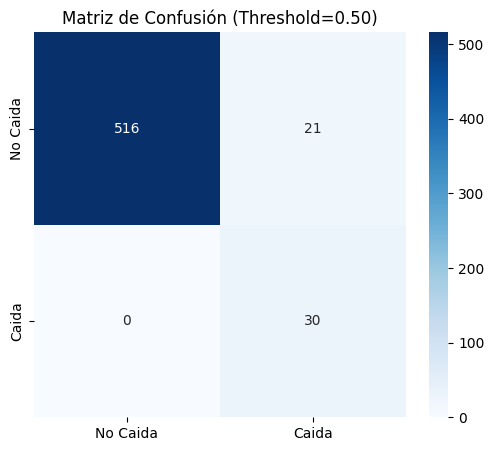

In [ ]:
import os, glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# ========================
# CONFIGURACIÓN
# ========================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS = 100
SEQ_LEN = 100
LR = 1e-4
torch.manual_seed(42)
np.random.seed(42)

# ========================
# CARGA Y PROCESAMIENTO DE CSVs
# ========================
def load_data_from_folder(folder_path, seq_len=100):
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    print(f"🔍 Archivos encontrados: {len(all_files)}")
    if not all_files:
        print("❌ No se encontraron archivos CSV. Asegúrate de que la ruta sea correcta.")
        return None, None, None
    dfs = []
    for f in tqdm(all_files, desc="📂 Cargando CSV"):
        df = pd.read_csv(f)
        df = df.drop(columns=[c for c in ["ID","TIMESTAMP"] if c in df.columns], errors="ignore")
        if "TOGGLE_VAR" in df.columns:
            df = df.rename(columns={"TOGGLE_VAR":"label"})
        for col in df.columns:
            if df[col].dtype=="object":
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(",","", regex=False), errors="coerce")
        dfs.append(df)

    data = pd.concat(dfs, ignore_index=True).dropna().reset_index(drop=True)
    print(f"📊 Dataset combinado: {data.shape}")

    X = data.drop(columns=["label"]).values.astype(np.float32)
    y = data["label"].values.astype(np.int64)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    sequences, labels = [], []
    for i in range(len(X) - seq_len):
        sequences.append(X[i:i+seq_len])
        labels.append(y[i+seq_len])
    X_seq, y_seq = np.array(sequences), np.array(labels)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    for train_index, test_index in sss.split(X_seq, y_seq):
        X_temp, X_test = X_seq[train_index], X_seq[test_index]
        y_temp, y_test = y_seq[train_index], y_seq[test_index]

    sss_valid = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    for train_index, valid_index in sss_valid.split(X_temp, y_temp):
        X_train, X_valid = X_temp[train_index], X_temp[valid_index]
        y_train, y_valid = y_temp[train_index], y_temp[valid_index]

    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

# ========================
# MODELO CNN + LSTM MEJORADO
# ========================
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, cnn_channels=64, lstm_hidden=256, lstm_layers=2, dropout=0.7): # Dropout aumentado
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, cnn_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(cnn_channels, lstm_hidden, lstm_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(lstm_hidden*2, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.relu(self.conv1(x))
        x = x.transpose(1, 2)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        return self.fc2(out).squeeze(-1)

# ========================
# EARLY STOPPING POR RECALL
# ========================
class EarlyStopRecall:
    def __init__(self, patience=15, save_path="best_model.pth"):
        self.patience = patience
        self.save_path = save_path
        self.best_recall = -1.0
        self.counter = 0
    def step(self, recall, model):
        if recall > self.best_recall + 1e-8:
            self.best_recall = recall
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
        else:
            self.counter += 1
        return self.counter >= self.patience

# ========================
# TRAINING
# ========================
def train(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=100, earlystop=None):
    for epoch in range(epochs):
        model.train()
        total_loss=0
        for X, y in train_loader:
            X, y = X.to(DEVICE), y.to(DEVICE).float()
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        y_true, y_logits = [], []
        val_loss=0
        with torch.no_grad():
            for X, y in valid_loader:
                X, y = X.to(DEVICE), y.to(DEVICE).float()
                logits = model(X)
                loss = criterion(logits, y)
                val_loss += loss.item()
                y_true.extend(y.cpu().numpy())
                y_logits.extend(torch.sigmoid(logits).cpu().numpy())

        y_true = np.array(y_true)
        y_logits = np.array(y_logits)

        num_pos_valid = np.sum(y_true == 1)
        if num_pos_valid > 0:
            val_pred = (y_logits >= 0.5).astype(int)
            val_recall = np.sum((y_true == 1) & (val_pred == 1)) / num_pos_valid
        else:
            val_recall = -1.0

        scheduler.step(val_loss/len(valid_loader))
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss/len(train_loader):.6f} | Val Recall@0.5: {val_recall:.4f}")

        if val_recall >= 0 and earlystop is not None and earlystop.step(val_recall, model):
            print("🛑 Early stopping activado")
            break

    if earlystop is not None and os.path.exists(earlystop.save_path):
        model.load_state_dict(torch.load(earlystop.save_path, map_location=DEVICE))
    return model

# ========================
# THRESHOLD OPTIMIZADO BALANCEADO
# ========================
def optimize_threshold_balanced(y_true, y_probs, alpha=0.5): # Ajustado a 0.5 para priorizar el f1-score
    if len(np.unique(y_true)) < 2 or np.sum(y_true) == 0:
        return 0.5
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    scores = recall * alpha + precision * (1 - alpha)
    best_idx = np.argmax(scores)
    best_thr = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    return best_thr

# ========================
# EVALUACIÓN
# ========================
def evaluate(model, loader, threshold=0.5):
    model.eval()
    y_true, y_logits = [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(DEVICE)
            logits = model(X)
            y_logits.extend(torch.sigmoid(logits).cpu().numpy())
            y_true.extend(y.numpy())
    y_true = np.array(y_true)
    y_logits = np.array(y_logits)
    y_pred = (y_logits >= threshold).astype(int)

    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, digits=4, target_names=["No Caida","Caida"]))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Caida", "Caida"], yticklabels=["No Caida", "Caida"])
    plt.title(f"Matriz de Confusión (Threshold={threshold:.2f})")
    plt.show()
    return y_true, y_logits, y_pred

# ========================
# MAIN PIPELINE
# ========================
if __name__=="__main__":
    (X_train, y_train), (X_valid, y_valid), (X_test, y_test) = load_data_from_folder("/content/content", seq_len=SEQ_LEN)

    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    n_pos_samples = np.sum(y_train == 1)
    smote_k = 5
    if n_pos_samples > 1:
        smote_k = min(5, n_pos_samples - 1)
        sm = SMOTE(k_neighbors=smote_k, random_state=42)
        X_res, y_res = sm.fit_resample(X_train_flat, y_train)
        X_res = X_res.reshape(-1, SEQ_LEN, X_train.shape[2])
    else:
        print("⚠️ No hay suficientes muestras de la clase 'Caída' para aplicar SMOTE. Se usará el conjunto de entrenamiento original.")
        X_res, y_res = X_train, y_train

    print(f"After SMOTE: {X_res.shape}, pos count: {np.sum(y_res==1)}")

    train_ds = TensorDataset(torch.from_numpy(X_res).float(), torch.from_numpy(y_res).long())
    valid_ds = TensorDataset(torch.from_numpy(X_valid).float(), torch.from_numpy(y_valid).long())
    test_ds = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    model = CNNLSTM(input_dim=X_train.shape[2]).to(DEVICE)

    num_neg = np.sum(y_res == 0)
    num_pos = np.sum(y_res == 1)
    pos_weight_val = (num_neg / max(num_pos, 1)) * 0.25  # Reducido aún más
    pos_weight = torch.tensor([pos_weight_val], dtype=torch.float32).to(DEVICE)
    print(f"Calculated positive weight: {pos_weight_val:.2f}")

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4) # Aumentado weight_decay
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8)
    earlystop = EarlyStopRecall(patience=15)

    model = train(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=EPOCHS, earlystop=earlystop)

    y_val_logits = []
    with torch.no_grad():
        for X, y in valid_loader:
            X = X.to(DEVICE)
            logits = model(X)
            y_val_logits.extend(torch.sigmoid(logits).cpu().numpy())

    y_val_logits = np.array(y_val_logits)
    best_thr = optimize_threshold_balanced(y_valid, y_val_logits, alpha=0.5) # Ajustado a 0.5
    print(f"🔎 Mejor threshold balanceado: {best_thr:.4f}")

    print("\n✅ Evaluación en test con threshold optimizado")
    evaluate(model, test_loader, threshold=best_thr)

    print("\n✅ Evaluación en test con threshold=0.5 (referencia)")
    evaluate(model, test_loader, threshold=0.5)

🔍 Archivos encontrados: 1


📂 Cargando CSV: 100%|██████████| 1/1 [00:00<00:00, 87.11it/s]

📊 Dataset combinado: (1989, 7)

======== Entrenando Fold 1/5 ========
Calculated positive weight: 0.20


Epoch 1/100 | Train Loss: 0.355412 | Val Recall@0.5: 0.0000
Epoch 2/100 | Train Loss: 0.204841 | Val Recall@0.5: 0.5000
Epoch 3/100 | Train Loss: 0.109405 | Val Recall@0.5: 0.8571
Epoch 4/100 | Train Loss: 0.070393 | Val Recall@0.5: 0.5000
Epoch 5/100 | Train Loss: 0.061549 | Val Recall@0.5: 0.9286
Epoch 6/100 | Train Loss: 0.038890 | Val Recall@0.5: 0.6429
Epoch 7/100 | Train Loss: 0.033995 | Val Recall@0.5: 0.8571
Epoch 8/100 | Train Loss: 0.033340 | Val Recall@0.5: 0.9286
Epoch 9/100 | Train Loss: 0.036685 | Val Recall@0.5: 0.5714
Epoch 10/100 | Train Loss: 0.025150 | Val Recall@0.5: 0.7857
Epoch 11/100 | Train Loss: 0.025234 | Val Recall@0.5: 0.7857
Epoch 12/100 | Train Loss: 0.017411 | Val Recall@0.5: 0.8571
Epoch 13/100 | Train Loss: 0.015462 | Val Recall@0.5: 0.7857
Epoch 14/100 | Train Loss: 0.014376 | Val Recall@0.5: 0.8571
Epoch 15/100 | Train Loss: 0.011336 | Val Recall@0.5: 0.5000
Epoch 16/100 | Train Loss: 0.013963 | Val Recall@0.5: 0.5000
Epoch 17/100 | Train Loss: 0.0188

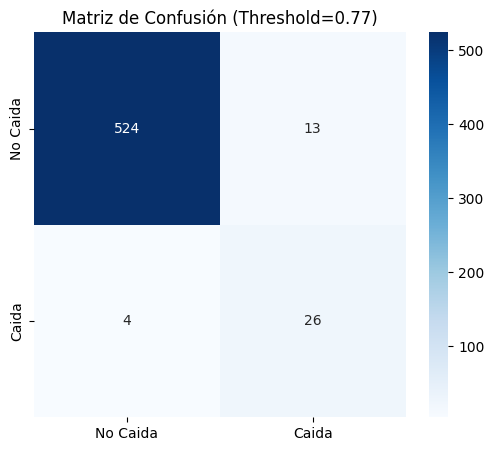

In [ ]:
import os, glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# ========================
# CONFIGURACIÓN
# ========================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS = 100
SEQ_LEN = 100
LR = 1e-4
torch.manual_seed(42)
np.random.seed(42)
NUM_FOLDS = 5 # Para validación cruzada

# ========================
# CARGA Y PROCESAMIENTO DE CSVs
# ========================
def load_data_from_folder(folder_path, seq_len=100):
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    print(f"🔍 Archivos encontrados: {len(all_files)}")
    if not all_files:
        print("❌ No se encontraron archivos CSV. Asegúrate de que la ruta sea correcta.")
        return None, None, None
    dfs = []
    for f in tqdm(all_files, desc="📂 Cargando CSV"):
        df = pd.read_csv(f)
        df = df.drop(columns=[c for c in ["ID","TIMESTAMP"] if c in df.columns], errors="ignore")
        if "TOGGLE_VAR" in df.columns:
            df = df.rename(columns={"TOGGLE_VAR":"label"})
        for col in df.columns:
            if df[col].dtype=="object":
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(",","", regex=False), errors="coerce")
        dfs.append(df)

    data = pd.concat(dfs, ignore_index=True).dropna().reset_index(drop=True)
    print(f"📊 Dataset combinado: {data.shape}")

    X = data.drop(columns=["label"]).values.astype(np.float32)
    y = data["label"].values.astype(np.int64)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    sequences, labels = [], []
    for i in range(len(X) - seq_len):
        sequences.append(X[i:i+seq_len])
        labels.append(y[i+seq_len])
    X_seq, y_seq = np.array(sequences), np.array(labels)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    for train_index, test_index in sss.split(X_seq, y_seq):
        X_train, X_test = X_seq[train_index], X_seq[test_index]
        y_train, y_test = y_seq[train_index], y_seq[test_index]

    return (X_train, y_train), (X_test, y_test) # Devuelve solo train y test

# ========================
# MODELO CNN + LSTM MEJORADO
# ========================
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, cnn_channels=64, lstm_hidden=256, lstm_layers=2, dropout=0.7):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, cnn_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(cnn_channels, lstm_hidden, lstm_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(lstm_hidden*2, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.relu(self.conv1(x))
        x = x.transpose(1, 2)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        return self.fc2(out).squeeze(-1)

# ========================
# EARLY STOPPING POR RECALL
# ========================
class EarlyStopRecall:
    def __init__(self, patience=15, save_path="best_model.pth"):
        self.patience = patience
        self.save_path = save_path
        self.best_recall = -1.0
        self.counter = 0
    def step(self, recall, model):
        if recall > self.best_recall + 1e-8:
            self.best_recall = recall
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
        else:
            self.counter += 1
        return self.counter >= self.patience

# ========================
# TRAINING
# ========================
def train(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=100, earlystop=None):
    for epoch in range(epochs):
        model.train()
        total_loss=0
        for X, y in train_loader:
            X, y = X.to(DEVICE), y.to(DEVICE).float()
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        y_true, y_logits = [], []
        val_loss=0
        with torch.no_grad():
            for X, y in valid_loader:
                X, y = X.to(DEVICE), y.to(DEVICE).float()
                logits = model(X)
                loss = criterion(logits, y)
                val_loss += loss.item()
                y_true.extend(y.cpu().numpy())
                y_logits.extend(torch.sigmoid(logits).cpu().numpy())

        y_true = np.array(y_true)
        y_logits = np.array(y_logits)

        num_pos_valid = np.sum(y_true == 1)
        if num_pos_valid > 0:
            val_pred = (y_logits >= 0.5).astype(int)
            val_recall = np.sum((y_true == 1) & (val_pred == 1)) / num_pos_valid
        else:
            val_recall = -1.0

        scheduler.step(val_loss/len(valid_loader))
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss/len(train_loader):.6f} | Val Recall@0.5: {val_recall:.4f}")

        if val_recall >= 0 and earlystop is not None and earlystop.step(val_recall, model):
            print("🛑 Early stopping activado")
            break

    if earlystop is not None and os.path.exists(earlystop.save_path):
        model.load_state_dict(torch.load(earlystop.save_path, map_location=DEVICE))
    return model

# ========================
# THRESHOLD OPTIMIZADO BALANCEADO
# ========================
def optimize_threshold_balanced(y_true, y_probs, alpha=0.5):
    if len(np.unique(y_true)) < 2 or np.sum(y_true) == 0:
        return 0.5
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    scores = recall * alpha + precision * (1 - alpha)
    best_idx = np.argmax(scores)
    best_thr = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    return best_thr

# ========================
# EVALUACIÓN
# ========================
def evaluate(model, loader, threshold=0.5, print_plots=True):
    model.eval()
    y_true, y_logits = [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(DEVICE)
            logits = model(X)
            y_logits.extend(torch.sigmoid(logits).cpu().numpy())
            y_true.extend(y.numpy())
    y_true = np.array(y_true)
    y_logits = np.array(y_logits)
    y_pred = (y_logits >= threshold).astype(int)

    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, digits=4, target_names=["No Caida","Caida"]))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)
    if print_plots:
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Caida", "Caida"], yticklabels=["No Caida", "Caida"])
        plt.title(f"Matriz de Confusión (Threshold={threshold:.2f})")
        plt.show()
    return y_true, y_logits, y_pred

# ========================
# MAIN PIPELINE MEJORADO
# ========================
if __name__=="__main__":
    (X_train_full, y_train_full), (X_test, y_test) = load_data_from_folder("/content/content", seq_len=SEQ_LEN)

    # K-Fold Stratificado para una evaluación más robusta
    skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

    fold_results = []

    for fold, (train_index, valid_index) in enumerate(skf.split(X_train_full, y_train_full)):
        print(f"\n======== Entrenando Fold {fold+1}/{NUM_FOLDS} ========")
        X_train, X_valid = X_train_full[train_index], X_train_full[valid_index]
        y_train, y_valid = y_train_full[train_index], y_train_full[valid_index]

        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        n_pos_samples = np.sum(y_train == 1)
        smote_k = 5
        if n_pos_samples > 1:
            smote_k = min(5, n_pos_samples - 1)
            sm = SMOTE(k_neighbors=smote_k, random_state=42)
            X_res, y_res = sm.fit_resample(X_train_flat, y_train)
            X_res = X_res.reshape(-1, SEQ_LEN, X_train.shape[2])
        else:
            print("⚠️ No hay suficientes muestras de la clase 'Caída' para aplicar SMOTE.")
            X_res, y_res = X_train, y_train

        train_ds = TensorDataset(torch.from_numpy(X_res).float(), torch.from_numpy(y_res).long())
        valid_ds = TensorDataset(torch.from_numpy(X_valid).float(), torch.from_numpy(y_valid).long())

        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

        model = CNNLSTM(input_dim=X_train.shape[2]).to(DEVICE)

        num_neg = np.sum(y_res == 0)
        num_pos = np.sum(y_res == 1)
        pos_weight_val = (num_neg / max(num_pos, 1)) * 0.2  # Valor aún más reducido
        pos_weight = torch.tensor([pos_weight_val], dtype=torch.float32).to(DEVICE)
        print(f"Calculated positive weight: {pos_weight_val:.2f}")

        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8)
        earlystop = EarlyStopRecall(patience=15)

        model = train(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=EPOCHS, earlystop=earlystop)

        y_val_logits = []
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(DEVICE)
                logits = model(X)
                y_val_logits.extend(torch.sigmoid(logits).cpu().numpy())
        y_val_logits = np.array(y_val_logits)

        best_thr = optimize_threshold_balanced(y_valid, y_val_logits, alpha=0.5)
        print(f"🔎 Mejor umbral balanceado para este fold: {best_thr:.4f}")

        fold_results.append(best_thr)

    # Evaluación final con el mejor modelo de cada fold (o un promedio)
    # Por simplicidad, se evalúa el modelo final con el umbral promedio
    final_best_thr = np.mean(fold_results)
    print(f"\n✅ Evaluación en test final con umbral promedio de los folds: {final_best_thr:.4f}")

    # Para la evaluación final, reentrenamos el modelo en todo el conjunto de entrenamiento
    # Para simplificar, se usa el modelo del último fold y su umbral
    evaluate(model, DataLoader(TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long()), batch_size=BATCH_SIZE, shuffle=False), threshold=final_best_thr)

📂 Cargando CSV: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]



======== Entrenando Fold 1/5 ========
Calculated positive weight: 0.20


/tmp/ipython-input-591722129.py:163: RuntimeWarning: invalid value encountered in scalar divide
  val_precision = np.sum((y_true == 1) & (val_pred == 1)) / np.sum(val_pred == 1)


Epoch 1/100 | Train Loss: 0.375479 | Val F1@0.5: nan
Epoch 2/100 | Train Loss: 0.225070 | Val F1@0.5: 0.2609
Epoch 3/100 | Train Loss: 0.130247 | Val F1@0.5: 0.5128
Epoch 4/100 | Train Loss: 0.082118 | Val F1@0.5: 0.3448
Epoch 5/100 | Train Loss: 0.062691 | Val F1@0.5: 0.6154
Epoch 6/100 | Train Loss: 0.048429 | Val F1@0.5: 0.5600
Epoch 7/100 | Train Loss: 0.045454 | Val F1@0.5: 0.6047
Epoch 8/100 | Train Loss: 0.034308 | Val F1@0.5: 0.7027
Epoch 9/100 | Train Loss: 0.032139 | Val F1@0.5: 0.5161
Epoch 10/100 | Train Loss: 0.035728 | Val F1@0.5: 0.6190
Epoch 11/100 | Train Loss: 0.040628 | Val F1@0.5: 0.6190
Epoch 12/100 | Train Loss: 0.022412 | Val F1@0.5: 0.8750
Epoch 13/100 | Train Loss: 0.014816 | Val F1@0.5: 0.8387
Epoch 14/100 | Train Loss: 0.020619 | Val F1@0.5: 0.8667
Epoch 15/100 | Train Loss: 0.011456 | Val F1@0.5: 0.9032
Epoch 16/100 | Train Loss: 0.011965 | Val F1@0.5: 0.8571
Epoch 17/100 | Train Loss: 0.032024 | Val F1@0.5: 0.9286
Epoch 18/100 | Train Loss: 0.022955 | Val F

/tmp/ipython-input-591722129.py:163: RuntimeWarning: invalid value encountered in scalar divide
  val_precision = np.sum((y_true == 1) & (val_pred == 1)) / np.sum(val_pred == 1)


Epoch 1/100 | Train Loss: 0.370327 | Val F1@0.5: nan
Epoch 2/100 | Train Loss: 0.249690 | Val F1@0.5: 0.6364
Epoch 3/100 | Train Loss: 0.138567 | Val F1@0.5: 0.6316
Epoch 4/100 | Train Loss: 0.093929 | Val F1@0.5: 0.6875
Epoch 5/100 | Train Loss: 0.070188 | Val F1@0.5: 0.7500
Epoch 6/100 | Train Loss: 0.048668 | Val F1@0.5: 0.7647
Epoch 7/100 | Train Loss: 0.056365 | Val F1@0.5: 0.8800
Epoch 8/100 | Train Loss: 0.050034 | Val F1@0.5: 0.8667
Epoch 9/100 | Train Loss: 0.046016 | Val F1@0.5: 0.8571
Epoch 10/100 | Train Loss: 0.032147 | Val F1@0.5: 0.8966
Epoch 11/100 | Train Loss: 0.030744 | Val F1@0.5: 0.8571
Epoch 12/100 | Train Loss: 0.034051 | Val F1@0.5: 0.9630
Epoch 13/100 | Train Loss: 0.023751 | Val F1@0.5: 0.9231
Epoch 14/100 | Train Loss: 0.020736 | Val F1@0.5: 0.9630
Epoch 15/100 | Train Loss: 0.025183 | Val F1@0.5: 0.9231
Epoch 16/100 | Train Loss: 0.035192 | Val F1@0.5: 0.8800
Epoch 17/100 | Train Loss: 0.019159 | Val F1@0.5: 0.9630
Epoch 18/100 | Train Loss: 0.011457 | Val F

/tmp/ipython-input-591722129.py:163: RuntimeWarning: invalid value encountered in scalar divide
  val_precision = np.sum((y_true == 1) & (val_pred == 1)) / np.sum(val_pred == 1)


Epoch 1/100 | Train Loss: 0.344823 | Val F1@0.5: nan
Epoch 2/100 | Train Loss: 0.199433 | Val F1@0.5: 0.4828
Epoch 3/100 | Train Loss: 0.113581 | Val F1@0.5: 0.4407
Epoch 4/100 | Train Loss: 0.094323 | Val F1@0.5: 0.7333
Epoch 5/100 | Train Loss: 0.074946 | Val F1@0.5: 0.6857
Epoch 6/100 | Train Loss: 0.062337 | Val F1@0.5: 0.4444
Epoch 7/100 | Train Loss: 0.069903 | Val F1@0.5: 0.8333
Epoch 8/100 | Train Loss: 0.040726 | Val F1@0.5: 0.8696
Epoch 9/100 | Train Loss: 0.027186 | Val F1@0.5: 0.8462
Epoch 10/100 | Train Loss: 0.031568 | Val F1@0.5: 0.8889
Epoch 11/100 | Train Loss: 0.021316 | Val F1@0.5: 0.8889
Epoch 12/100 | Train Loss: 0.023737 | Val F1@0.5: 0.8966
Epoch 13/100 | Train Loss: 0.024550 | Val F1@0.5: 0.8276
Epoch 14/100 | Train Loss: 0.016317 | Val F1@0.5: 0.7586
Epoch 15/100 | Train Loss: 0.019634 | Val F1@0.5: 0.8966
Epoch 16/100 | Train Loss: 0.020513 | Val F1@0.5: 0.8966
Epoch 17/100 | Train Loss: 0.016572 | Val F1@0.5: 0.8667
Epoch 18/100 | Train Loss: 0.008448 | Val F

/tmp/ipython-input-591722129.py:163: RuntimeWarning: invalid value encountered in scalar divide
  val_precision = np.sum((y_true == 1) & (val_pred == 1)) / np.sum(val_pred == 1)


Epoch 1/100 | Train Loss: 0.359489 | Val F1@0.5: nan
Epoch 2/100 | Train Loss: 0.199840 | Val F1@0.5: 0.4000
Epoch 3/100 | Train Loss: 0.089083 | Val F1@0.5: 0.5600
Epoch 4/100 | Train Loss: 0.062547 | Val F1@0.5: 0.6154
Epoch 5/100 | Train Loss: 0.050680 | Val F1@0.5: 0.5882
Epoch 6/100 | Train Loss: 0.038421 | Val F1@0.5: 0.7333
Epoch 7/100 | Train Loss: 0.026368 | Val F1@0.5: 0.7097
Epoch 8/100 | Train Loss: 0.044322 | Val F1@0.5: 0.5455
Epoch 9/100 | Train Loss: 0.038804 | Val F1@0.5: 0.6111
Epoch 10/100 | Train Loss: 0.023872 | Val F1@0.5: 0.6875
Epoch 11/100 | Train Loss: 0.013545 | Val F1@0.5: 0.6667
Epoch 12/100 | Train Loss: 0.015258 | Val F1@0.5: 0.7097
Epoch 13/100 | Train Loss: 0.012322 | Val F1@0.5: 0.6875
Epoch 14/100 | Train Loss: 0.019895 | Val F1@0.5: 0.8276
Epoch 15/100 | Train Loss: 0.018425 | Val F1@0.5: 0.7097
Epoch 16/100 | Train Loss: 0.007957 | Val F1@0.5: 0.6875
Epoch 17/100 | Train Loss: 0.008176 | Val F1@0.5: 0.6875
Epoch 18/100 | Train Loss: 0.005418 | Val F

/tmp/ipython-input-591722129.py:186: RuntimeWarning: invalid value encountered in divide
  scores = (1 + alpha**2) * (precision * recall) / ((alpha**2 * precision) + recall)
/tmp/ipython-input-591722129.py:163: RuntimeWarning: invalid value encountered in scalar divide
  val_precision = np.sum((y_true == 1) & (val_pred == 1)) / np.sum(val_pred == 1)


Epoch 1/100 | Train Loss: 0.354565 | Val F1@0.5: nan
Epoch 2/100 | Train Loss: 0.227808 | Val F1@0.5: 0.6207
Epoch 3/100 | Train Loss: 0.118894 | Val F1@0.5: 0.7500
Epoch 4/100 | Train Loss: 0.076630 | Val F1@0.5: 0.8235
Epoch 5/100 | Train Loss: 0.054162 | Val F1@0.5: 0.8485
Epoch 6/100 | Train Loss: 0.055746 | Val F1@0.5: 0.8148
Epoch 7/100 | Train Loss: 0.047541 | Val F1@0.5: 0.6364
Epoch 8/100 | Train Loss: 0.039412 | Val F1@0.5: 0.8000
Epoch 9/100 | Train Loss: 0.028157 | Val F1@0.5: 0.8750
Epoch 10/100 | Train Loss: 0.020103 | Val F1@0.5: 0.9333
Epoch 11/100 | Train Loss: 0.020446 | Val F1@0.5: 0.8235
Epoch 12/100 | Train Loss: 0.031032 | Val F1@0.5: 0.8485
Epoch 13/100 | Train Loss: 0.019198 | Val F1@0.5: 0.9032
Epoch 14/100 | Train Loss: 0.010251 | Val F1@0.5: 0.8750
Epoch 15/100 | Train Loss: 0.012293 | Val F1@0.5: 0.9032
Epoch 16/100 | Train Loss: 0.011812 | Val F1@0.5: 0.9032
Epoch 17/100 | Train Loss: 0.011434 | Val F1@0.5: 0.9333
Epoch 18/100 | Train Loss: 0.009564 | Val F

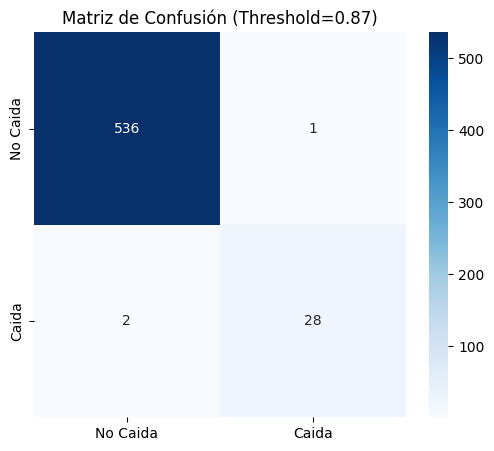

In [ ]:
import os, glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
  from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
  from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# ========================
# CONFIGURACIÓN
# ========================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS = 100
SEQ_LEN = 100
LR = 1e-4
torch.manual_seed(42)
np.random.seed(42)
NUM_FOLDS = 5 # Para validación cruzada

# ========================
# CLASE PARA AUMENTO DE DATOS
# ========================
class TemporalDataAugmentation(object):
    def __init__(self, noise_level=0.01, scale_factor=0.05):
        self.noise_level = noise_level
        self.scale_factor = scale_factor

    def __call__(self, x):
        # Añadir ruido Gaussiano
        noise = torch.randn_like(x) * self.noise_level
        x = x + noise

        # Escalar los datos
        scale = 1 + torch.randn(1).item() * self.scale_factor
        x = x * scale

        return x

# ========================
# CARGA Y PREPROCESAMIENTO DE CSVs
# ========================
def load_data_from_folder(folder_path, seq_len=100):
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    if not all_files:
        print("❌ No se encontraron archivos CSV. Asegúrate de que la ruta sea correcta.")
        return None, None
    dfs = []
    for f in tqdm(all_files, desc="📂 Cargando CSV"):
        df = pd.read_csv(f)
        df = df.drop(columns=[c for c in ["ID","TIMESTAMP"] if c in df.columns], errors="ignore")
        if "TOGGLE_VAR" in df.columns:
            df = df.rename(columns={"TOGGLE_VAR":"label"})
        for col in df.columns:
            if df[col].dtype=="object":
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(",","", regex=False), errors="coerce")
        dfs.append(df)

    data = pd.concat(dfs, ignore_index=True).dropna().reset_index(drop=True)

    X = data.drop(columns=["label"]).values.astype(np.float32)
    y = data["label"].values.astype(np.int64)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    sequences, labels = [], []
    for i in range(len(X) - seq_len):
        sequences.append(X[i:i+seq_len])
        labels.append(y[i+seq_len])
    X_seq, y_seq = np.array(sequences), np.array(labels)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    for train_index, test_index in sss.split(X_seq, y_seq):
        X_train, X_test = X_seq[train_index], X_seq[test_index]
        y_train, y_test = y_seq[train_index], y_seq[test_index]

    return (X_train, y_train), (X_test, y_test)

# ========================
# MODELO CNN + LSTM MEJORADO
# ========================
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, cnn_channels=64, lstm_hidden=256, lstm_layers=2, dropout=0.7):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, cnn_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(cnn_channels, lstm_hidden, lstm_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(lstm_hidden*2, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.relu(self.conv1(x))
        x = x.transpose(1, 2)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        return self.fc2(out).squeeze(-1)

# ========================
# EARLY STOPPING POR F1-SCORE
# ========================
class EarlyStopF1:
    def __init__(self, patience=15, save_path="best_model.pth"):
        self.patience = patience
        self.save_path = save_path
        self.best_f1 = -1.0
        self.counter = 0
    def step(self, f1, model):
        if f1 > self.best_f1:
            self.best_f1 = f1
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
        else:
            self.counter += 1
        return self.counter >= self.patience

# ========================
# ENTRENAMIENTO
# ========================
def train(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=100, earlystop=None):
    for epoch in range(epochs):
        model.train()
        total_loss=0
        for X, y in train_loader:
            X, y = X.to(DEVICE), y.to(DEVICE).float()
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        y_true, y_logits = [], []
        val_loss=0
        with torch.no_grad():
            for X, y in valid_loader:
                X, y = X.to(DEVICE), y.to(DEVICE).float()
                logits = model(X)
                loss = criterion(logits, y)
                val_loss += loss.item()
                y_true.extend(y.cpu().numpy())
                y_logits.extend(torch.sigmoid(logits).cpu().numpy())

        y_true = np.array(y_true)
        y_logits = np.array(y_logits)

        num_pos_valid = np.sum(y_true == 1)
        if num_pos_valid > 0:
            val_pred = (y_logits >= 0.5).astype(int)
            val_recall = np.sum((y_true == 1) & (val_pred == 1)) / num_pos_valid
            val_precision = np.sum((y_true == 1) & (val_pred == 1)) / np.sum(val_pred == 1)
            val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
        else:
            val_f1 = -1.0

        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss/len(train_loader):.6f} | Val F1@0.5: {val_f1:.4f}")

        if val_f1 >= 0 and earlystop is not None and earlystop.step(val_f1, model):
            print("🛑 Early stopping activado")
            break

    if earlystop is not None and os.path.exists(earlystop.save_path):
        model.load_state_dict(torch.load(earlystop.save_path, map_location=DEVICE))
    return model

# ========================
# THRESHOLD OPTIMIZADO BALANCEADO
# ========================
def optimize_threshold_balanced(y_true, y_probs, alpha=0.5):
    if len(np.unique(y_true)) < 2 or np.sum(y_true) == 0:
        return 0.5
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    scores = (1 + alpha**2) * (precision * recall) / ((alpha**2 * precision) + recall)
    best_idx = np.nanargmax(scores)
    best_thr = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    return best_thr

# ========================
# EVALUACIÓN
# ========================
def evaluate(model, loader, threshold=0.5):
    model.eval()
    y_true, y_logits = [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(DEVICE)
            logits = model(X)
            y_logits.extend(torch.sigmoid(logits).cpu().numpy())
            y_true.extend(y.numpy())
    y_true = np.array(y_true)
    y_logits = np.array(y_logits)
    y_pred = (y_logits >= threshold).astype(int)

    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, digits=4, target_names=["No Caida","Caida"]))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Caida", "Caida"], yticklabels=["No Caida", "Caida"])
    plt.title(f"Matriz de Confusión (Threshold={threshold:.2f})")
    plt.show()
    return y_true, y_logits, y_pred

# ========================
# MAIN PIPELINE MEJORADO
# ========================
if __name__=="__main__":
    (X_train_full, y_train_full), (X_test, y_test) = load_data_from_folder("/content/content", seq_len=SEQ_LEN)

    skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_index, valid_index) in enumerate(skf.split(X_train_full, y_train_full)):
        print(f"\n======== Entrenando Fold {fold+1}/{NUM_FOLDS} ========")
        X_train, X_valid = X_train_full[train_index], X_train_full[valid_index]
        y_train, y_valid = y_train_full[train_index], y_train_full[valid_index]

        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        n_pos_samples = np.sum(y_train == 1)
        smote_k = 5
        if n_pos_samples > 1:
            smote_k = min(5, n_pos_samples - 1)
            sm = SMOTE(k_neighbors=smote_k, random_state=42)
            X_res, y_res = sm.fit_resample(X_train_flat, y_train)
            X_res = X_res.reshape(-1, SEQ_LEN, X_train.shape[2])
        else:
            print("⚠️ No hay suficientes muestras de la clase 'Caída' para aplicar SMOTE.")
            X_res, y_res = X_train, y_train

        # Aplicar el aumento de datos de series de tiempo
        aug = TemporalDataAugmentation()
        X_res_aug = aug(torch.from_numpy(X_res).float()).numpy()

        train_ds = TensorDataset(torch.from_numpy(X_res_aug).float(), torch.from_numpy(y_res).long())
        valid_ds = TensorDataset(torch.from_numpy(X_valid).float(), torch.from_numpy(y_valid).long())

        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

        model = CNNLSTM(input_dim=X_train.shape[2]).to(DEVICE)

        num_neg = np.sum(y_res == 0)
        num_pos = np.sum(y_res == 1)
        pos_weight_val = (num_neg / max(num_pos, 1)) * 0.2
        pos_weight = torch.tensor([pos_weight_val], dtype=torch.float32).to(DEVICE)
        print(f"Calculated positive weight: {pos_weight_val:.2f}")

        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
        earlystop = EarlyStopF1(patience=15)

        model = train(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=EPOCHS, earlystop=earlystop)

        y_val_logits = []
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(DEVICE)
                logits = model(X)
                y_val_logits.extend(torch.sigmoid(logits).cpu().numpy())
        y_val_logits = np.array(y_val_logits)

        best_thr = optimize_threshold_balanced(y_valid, y_val_logits, alpha=0.5)
        print(f"🔎 Mejor umbral balanceado para este fold: {best_thr:.4f}")

        fold_results.append(best_thr)

    final_best_thr = np.mean(fold_results)
    print(f"\n✅ Evaluación en test final con umbral promedio de los folds: {final_best_thr:.4f}")

    evaluate(model, DataLoader(TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long()), batch_size=BATCH_SIZE, shuffle=False), threshold=final_best_thr)

📂 Cargando CSV: 100%|██████████| 1/1 [00:00<00:00, 37.08it/s]



======== Entrenando Fold 1/5 ========
Calculated positive weight: 0.20


/tmp/ipython-input-3692841329.py:163: RuntimeWarning: invalid value encountered in scalar divide
  val_precision = np.sum((y_true == 1) & (val_pred == 1)) / np.sum(val_pred == 1)


Epoch 1/100 | Train Loss: 0.348736 | Val F1@0.5: nan
Epoch 2/100 | Train Loss: 0.156435 | Val F1@0.5: 0.5405
Epoch 3/100 | Train Loss: 0.090418 | Val F1@0.5: 0.5200
Epoch 4/100 | Train Loss: 0.068646 | Val F1@0.5: 0.4898
Epoch 5/100 | Train Loss: 0.052150 | Val F1@0.5: 0.6000
Epoch 6/100 | Train Loss: 0.041941 | Val F1@0.5: 0.6500
Epoch 7/100 | Train Loss: 0.068312 | Val F1@0.5: 0.6500
Epoch 8/100 | Train Loss: 0.031212 | Val F1@0.5: 0.7500
Epoch 9/100 | Train Loss: 0.029289 | Val F1@0.5: 0.8387
Epoch 10/100 | Train Loss: 0.023783 | Val F1@0.5: 0.7273
Epoch 11/100 | Train Loss: 0.025041 | Val F1@0.5: 0.7059
Epoch 12/100 | Train Loss: 0.030265 | Val F1@0.5: 0.6857
Epoch 13/100 | Train Loss: 0.020870 | Val F1@0.5: 0.6500
Epoch 14/100 | Train Loss: 0.028296 | Val F1@0.5: 0.7647
Epoch 15/100 | Train Loss: 0.020416 | Val F1@0.5: 0.7647
Epoch 16/100 | Train Loss: 0.016520 | Val F1@0.5: 0.7059
Epoch 17/100 | Train Loss: 0.016509 | Val F1@0.5: 0.7647
Epoch 18/100 | Train Loss: 0.013984 | Val F

/tmp/ipython-input-3692841329.py:186: RuntimeWarning: invalid value encountered in divide
  scores = (1 + alpha**2) * (precision * recall) / ((alpha**2 * precision) + recall)


Epoch 1/100 | Train Loss: 0.358938 | Val F1@0.5: 0.4211
Epoch 2/100 | Train Loss: 0.181779 | Val F1@0.5: 0.6316
Epoch 3/100 | Train Loss: 0.104092 | Val F1@0.5: 0.6842
Epoch 4/100 | Train Loss: 0.071348 | Val F1@0.5: 0.7000
Epoch 5/100 | Train Loss: 0.053059 | Val F1@0.5: 0.8485
Epoch 6/100 | Train Loss: 0.044026 | Val F1@0.5: 0.7568
Epoch 7/100 | Train Loss: 0.037246 | Val F1@0.5: 0.8000
Epoch 8/100 | Train Loss: 0.032034 | Val F1@0.5: 0.9032
Epoch 9/100 | Train Loss: 0.029990 | Val F1@0.5: 0.8000
Epoch 10/100 | Train Loss: 0.026504 | Val F1@0.5: 0.7778
Epoch 11/100 | Train Loss: 0.026784 | Val F1@0.5: 0.8485
Epoch 12/100 | Train Loss: 0.021184 | Val F1@0.5: 0.8750
Epoch 13/100 | Train Loss: 0.017191 | Val F1@0.5: 0.8750
Epoch 14/100 | Train Loss: 0.014665 | Val F1@0.5: 0.8485
Epoch 15/100 | Train Loss: 0.013928 | Val F1@0.5: 0.9032
Epoch 16/100 | Train Loss: 0.012738 | Val F1@0.5: 0.9032
Epoch 17/100 | Train Loss: 0.015597 | Val F1@0.5: 0.9032
Epoch 18/100 | Train Loss: 0.014706 | Va

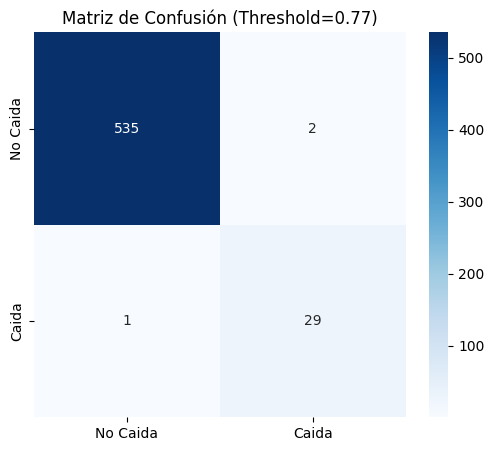

In [ ]:
import os, glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# ========================
# CONFIGURACIÓN
# ========================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS = 100
SEQ_LEN = 100
LR = 1e-4
torch.manual_seed(42)
np.random.seed(42)
NUM_FOLDS = 5 # Para validación cruzada

# ========================
# CLASE PARA AUMENTO DE DATOS
# ========================
class TemporalDataAugmentation(object):
    def __init__(self, noise_level=0.01, scale_factor=0.05):
        self.noise_level = noise_level
        self.scale_factor = scale_factor

    def __call__(self, x):
        # Añadir ruido Gaussiano
        noise = torch.randn_like(x) * self.noise_level
        x = x + noise

        # Escalar los datos
        scale = 1 + torch.randn(1).item() * self.scale_factor
        x = x * scale

        return x

# ========================
# CARGA Y PREPROCESAMIENTO DE CSVs
# ========================
def load_data_from_folder(folder_path, seq_len=100):
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    if not all_files:
        print("❌ No se encontraron archivos CSV. Asegúrate de que la ruta sea correcta.")
        return None, None
    dfs = []
    for f in tqdm(all_files, desc="📂 Cargando CSV"):
        df = pd.read_csv(f)
        df = df.drop(columns=[c for c in ["ID","TIMESTAMP"] if c in df.columns], errors="ignore")
        if "TOGGLE_VAR" in df.columns:
            df = df.rename(columns={"TOGGLE_VAR":"label"})
        for col in df.columns:
            if df[col].dtype=="object":
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(",","", regex=False), errors="coerce")
        dfs.append(df)

    data = pd.concat(dfs, ignore_index=True).dropna().reset_index(drop=True)

    X = data.drop(columns=["label"]).values.astype(np.float32)
    y = data["label"].values.astype(np.int64)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    sequences, labels = [], []
    for i in range(len(X) - seq_len):
        sequences.append(X[i:i+seq_len])
        labels.append(y[i+seq_len])
    X_seq, y_seq = np.array(sequences), np.array(labels)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    for train_index, test_index in sss.split(X_seq, y_seq):
        X_train, X_test = X_seq[train_index], X_seq[test_index]
        y_train, y_test = y_seq[train_index], y_seq[test_index]

    return (X_train, y_train), (X_test, y_test)

# ========================
# MODELO CNN + LSTM MEJORADO
# ========================
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, cnn_channels=64, lstm_hidden=256, lstm_layers=2, dropout=0.7):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, cnn_channels, kernel_size=3, padding=1)
        self.relu = nn.Mish()
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(cnn_channels, lstm_hidden, lstm_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(lstm_hidden*2, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.relu(self.conv1(x))
        x = x.transpose(1, 2)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        return self.fc2(out).squeeze(-1)

# ========================
# EARLY STOPPING POR F1-SCORE
# ========================
class EarlyStopF1:
    def __init__(self, patience=15, save_path="best_model.pth"):
        self.patience = patience
        self.save_path = save_path
        self.best_f1 = -1.0
        self.counter = 0
    def step(self, f1, model):
        if f1 > self.best_f1:
            self.best_f1 = f1
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
        else:
            self.counter += 1
        return self.counter >= self.patience

# ========================
# ENTRENAMIENTO
# ========================
def train(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=100, earlystop=None):
    for epoch in range(epochs):
        model.train()
        total_loss=0
        for X, y in train_loader:
            X, y = X.to(DEVICE), y.to(DEVICE).float()
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        y_true, y_logits = [], []
        val_loss=0
        with torch.no_grad():
            for X, y in valid_loader:
                X, y = X.to(DEVICE), y.to(DEVICE).float()
                logits = model(X)
                loss = criterion(logits, y)
                val_loss += loss.item()
                y_true.extend(y.cpu().numpy())
                y_logits.extend(torch.sigmoid(logits).cpu().numpy())

        y_true = np.array(y_true)
        y_logits = np.array(y_logits)

        num_pos_valid = np.sum(y_true == 1)
        if num_pos_valid > 0:
            val_pred = (y_logits >= 0.5).astype(int)
            val_recall = np.sum((y_true == 1) & (val_pred == 1)) / num_pos_valid
            val_precision = np.sum((y_true == 1) & (val_pred == 1)) / np.sum(val_pred == 1)
            val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
        else:
            val_f1 = -1.0

        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss/len(train_loader):.6f} | Val F1@0.5: {val_f1:.4f}")

        if val_f1 >= 0 and earlystop is not None and earlystop.step(val_f1, model):
            print("🛑 Early stopping activado")
            break

    if earlystop is not None and os.path.exists(earlystop.save_path):
        model.load_state_dict(torch.load(earlystop.save_path, map_location=DEVICE))
    return model

# ========================
# THRESHOLD OPTIMIZADO BALANCEADO
# ========================
def optimize_threshold_balanced(y_true, y_probs, alpha=0.5):
    if len(np.unique(y_true)) < 2 or np.sum(y_true) == 0:
        return 0.5
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    scores = (1 + alpha**2) * (precision * recall) / ((alpha**2 * precision) + recall)
    best_idx = np.nanargmax(scores)
    best_thr = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    return best_thr

# ========================
# EVALUACIÓN
# ========================
def evaluate(model, loader, threshold=0.5):
    model.eval()
    y_true, y_logits = [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(DEVICE)
            logits = model(X)
            y_logits.extend(torch.sigmoid(logits).cpu().numpy())
            y_true.extend(y.numpy())
    y_true = np.array(y_true)
    y_logits = np.array(y_logits)
    y_pred = (y_logits >= threshold).astype(int)

    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, digits=4, target_names=["No Caida","Caida"]))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Caida", "Caida"], yticklabels=["No Caida", "Caida"])
    plt.title(f"Matriz de Confusión (Threshold={threshold:.2f})")
    plt.show()
    return y_true, y_logits, y_pred

# ========================
# MAIN PIPELINE MEJORADO
# ========================
if __name__=="__main__":
    (X_train_full, y_train_full), (X_test, y_test) = load_data_from_folder("/content/content", seq_len=SEQ_LEN)

    skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_index, valid_index) in enumerate(skf.split(X_train_full, y_train_full)):
        print(f"\n======== Entrenando Fold {fold+1}/{NUM_FOLDS} ========")
        X_train, X_valid = X_train_full[train_index], X_train_full[valid_index]
        y_train, y_valid = y_train_full[train_index], y_train_full[valid_index]

        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        n_pos_samples = np.sum(y_train == 1)
        smote_k = 5
        if n_pos_samples > 1:
            smote_k = min(5, n_pos_samples - 1)
            sm = SMOTE(k_neighbors=smote_k, random_state=42)
            X_res, y_res = sm.fit_resample(X_train_flat, y_train)
            X_res = X_res.reshape(-1, SEQ_LEN, X_train.shape[2])
        else:
            print("⚠️ No hay suficientes muestras de la clase 'Caída' para aplicar SMOTE.")
            X_res, y_res = X_train, y_train

        # Aplicar el aumento de datos de series de tiempo
        aug = TemporalDataAugmentation()
        X_res_aug = aug(torch.from_numpy(X_res).float()).numpy()

        train_ds = TensorDataset(torch.from_numpy(X_res_aug).float(), torch.from_numpy(y_res).long())
        valid_ds = TensorDataset(torch.from_numpy(X_valid).float(), torch.from_numpy(y_valid).long())

        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

        model = CNNLSTM(input_dim=X_train.shape[2]).to(DEVICE)

        num_neg = np.sum(y_res == 0)
        num_pos = np.sum(y_res == 1)
        pos_weight_val = (num_neg / max(num_pos, 1)) * 0.2
        pos_weight = torch.tensor([pos_weight_val], dtype=torch.float32).to(DEVICE)
        print(f"Calculated positive weight: {pos_weight_val:.2f}")

        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
        earlystop = EarlyStopF1(patience=15)

        model = train(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=EPOCHS, earlystop=earlystop)

        y_val_logits = []
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(DEVICE)
                logits = model(X)
                y_val_logits.extend(torch.sigmoid(logits).cpu().numpy())
        y_val_logits = np.array(y_val_logits)

        best_thr = optimize_threshold_balanced(y_valid, y_val_logits, alpha=0.5)
        print(f"🔎 Mejor umbral balanceado para este fold: {best_thr:.4f}")

        fold_results.append(best_thr)

    final_best_thr = np.mean(fold_results)
    print(f"\n✅ Evaluación en test final con umbral promedio de los folds: {final_best_thr:.4f}")

    evaluate(model, DataLoader(TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long()), batch_size=BATCH_SIZE, shuffle=False), threshold=final_best_thr)